<a href="https://colab.research.google.com/github/adarsh-meher/CatGorical_Analysis_Kaggle/blob/master/CatGorical_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/adarsh-meher/CatGorical_Analysis_Kaggle.git

Cloning into 'CatGorical_Analysis_Kaggle'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 17 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (17/17), done.


In [0]:
import os
os.listdir()
os.chdir('/content/CatGorical_Analysis_Kaggle/')

In [0]:
!unzip '/content/CatGorical_Analysis_Kaggle/train.zip'

Archive:  /content/CatGorical_Analysis_Kaggle/train.zip
  inflating: train.csv               


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test['target'] = [0]*test.shape[0]

In [0]:
!pip install hyperopt
!pip install category_encoders
!pip install tpot
!pip install umap-learn
!pip install mca
!pip install h2o
!pip install catboost
!pip install lightgbm

     |████████████████████████████████| 102kB 3.7MB/s 
     |████████████████████████████████| 81kB 3.9MB/s 
     |████████████████████████████████| 153kB 14.6MB/s 
     |████████████████████████████████| 61kB 8.7MB/s 
  Created wheel for stopit: filename=stopit-1.1.2-cp36-none-any.whl size=11955 sha256=77c5a6db2c16e2ed7005a49dc4e49f4a5fdfe4322722fe32d655dc12b93f93c0
  Stored in directory: /root/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
Successfully built stopit
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


  Created wheel for mca: filename=mca-1.0.3-py2.py3-none-any.whl size=5999 sha256=a62a6834b184709cd3787973cf617fe2bcbcb1cbc2716b7a8cb4f3e0983a9631
  Stored in directory: /root/.cache/pip/wheels/01/fb/ff/19d72d65c8bb01d4af40c9c2ca20fd267d1969b3b5f8dd60d6
Successfully built mca
     |████████████████████████████████| 123.4MB 23kB/s 
  Created wheel for h2o: filename=h2o-3.28.0.1-py2.py3-none-any.whl size=123410554 sha256=d81544db0a37d36bb8725026b67222403566b97d4cef41d4e4066bb760f46589
  Stored in directory: /root/.cache/pip/wheels/ff/82/f4/3fe9c895b93c53b25ae44dc44aa54dad571c711f48bc485fe9
Successfully built h2o
     |████████████████████████████████| 63.9MB 52kB/s 


In [0]:
import category_encoders as ce
import mlxtend as mlx
import hyperopt as hopt
import featuretools as ft
import h2o
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sc
import tpot

In [0]:
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,StratifiedKFold
from sklearn.linear_model import LogisticRegression,RidgeClassifier,SGDClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier,VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import roc_auc_score,make_scorer
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [0]:
from catboost import CatBoostClassifier,Pool,cv
from catboost import train as cb_train
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
from sklearn.feature_selection import mutual_info_classif,SelectKBest,chi2,RFECV
import time
import warnings
from imblearn.over_sampling import RandomOverSampler
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
def reduce_mem_usage(data,print_res = True):
  num_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  curr_mem_usage = data.memory_usage().sum()/1024**2
  for c in data.columns.tolist():
    col_type = data[c].dtypes
    if col_type in num_types:
      col_min = data[c].min()
      col_max = data[c].max()

      if 'int' in str(col_type):
        if col_min>np.iinfo(np.int8).min and col_max<np.iinfo(np.int8).max:
          data[c] = data[c].astype(np.int8)
        elif col_min>np.iinfo(np.int16).min and col_max<np.iinfo(np.int16).max:
          data[c] = data[c].astype(np.int16)
        elif col_min>np.iinfo(np.int32).min and col_max<np.iinfo(np.int32).max:
          data[c] = data[c].astype(np.int32)
        elif col_min>np.iinfo(np.int64).min and col_max<np.iinfo(np.int64).max:
          data[c] = data[c].astype(np.int64)
        else:
          pass

      else:
        if col_min>np.finfo(np.float16).min and col_max<np.finfo(np.float16).max:
          data[c] = data[c].astype(np.int8)
        elif col_min>np.finfo(np.float32).min and col_max<np.finfo(np.float32).max:
          data[c] = data[c].astype(np.int16)
        elif col_min>np.finfo(np.float64).min and col_max<np.finfo(np.float64).max:
          data[c] = data[c].astype(np.int32)
        else:
          pass
    else:
      continue

  reduce_usage = data.memory_usage().sum()/1024**2
  if print_res: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(reduce_usage, 100 * (curr_mem_usage - reduce_usage) / curr_mem_usage))

  return data    

In [0]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 42.06 Mb (26.5% reduction)
Mem. usage decreased to 28.04 Mb (26.5% reduction)


In [0]:
#### Target variable distribution
train['target'].value_counts()/train.shape[0]
# 0    0.69412
# 1    0.30588

0    0.69412
1    0.30588
Name: target, dtype: float64

In [0]:
#### Numer of unique values in each variable in train and test
for i in train.columns:
    if i!='id':
        print('Number of Unique values in %s for train : %s and test : %s' % (i,train[i].nunique(),test[i].nunique()))

Number of Unique values in bin_0 for train : 2 and test : 2
Number of Unique values in bin_1 for train : 2 and test : 2
Number of Unique values in bin_2 for train : 2 and test : 2
Number of Unique values in bin_3 for train : 2 and test : 2
Number of Unique values in bin_4 for train : 2 and test : 2
Number of Unique values in nom_0 for train : 3 and test : 3
Number of Unique values in nom_1 for train : 6 and test : 6
Number of Unique values in nom_2 for train : 6 and test : 6
Number of Unique values in nom_3 for train : 6 and test : 6
Number of Unique values in nom_4 for train : 4 and test : 4
Number of Unique values in nom_5 for train : 222 and test : 222
Number of Unique values in nom_6 for train : 522 and test : 522
Number of Unique values in nom_7 for train : 1220 and test : 1219
Number of Unique values in nom_8 for train : 2215 and test : 2214
Number of Unique values in nom_9 for train : 11981 and test : 11839
Number of Unique values in ord_0 for train : 3 and test : 3
Number of Un

In [0]:
#### Columns where train and test have different category values
for i in train.columns.tolist():
    s1 = len(set(train[i].unique()).difference(set(test[i].unique())))
    s2 = len(set(test[i].unique()).difference(set(train[i].unique())))
    print('For variable %s : Category in train but not in test : %s and in test but not in train : %s' % (i,s1,s2))
    
### nom_7,nom_8,nom_9 are variables whcich have varying category labels in train and test

For variable id : Category in train but not in test : 300000 and in test but not in train : 200000
For variable bin_0 : Category in train but not in test : 0 and in test but not in train : 0
For variable bin_1 : Category in train but not in test : 0 and in test but not in train : 0
For variable bin_2 : Category in train but not in test : 0 and in test but not in train : 0
For variable bin_3 : Category in train but not in test : 0 and in test but not in train : 0
For variable bin_4 : Category in train but not in test : 0 and in test but not in train : 0
For variable nom_0 : Category in train but not in test : 0 and in test but not in train : 0
For variable nom_1 : Category in train but not in test : 0 and in test but not in train : 0
For variable nom_2 : Category in train but not in test : 0 and in test but not in train : 0
For variable nom_3 : Category in train but not in test : 0 and in test but not in train : 0
For variable nom_4 : Category in train but not in test : 0 and in test bu

In [0]:
df1 = pd.DataFrame({ k:train[k].nunique() for k in train.columns if k not in ['id','target']},index = [0]).T.reset_index()
high_card_feats = df1[df1[0]>12]['index'].values.tolist()
low_card_feats = df1[df1[0]<=12]['index'].values.tolist()

## **`EDA and Feature Engineering`**

In [0]:
train.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,50f116bcf,3ac1b8814,68f6ad3e9,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,b3b4d25d0,fbcb50fc1,3b6dd5612,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,3263bdce5,0922e3cb8,a6a36f527,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,f12246592,50d7ad46a,ec69236eb,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,5b0f5acd5,1fe17a1fd,04ddac2be,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


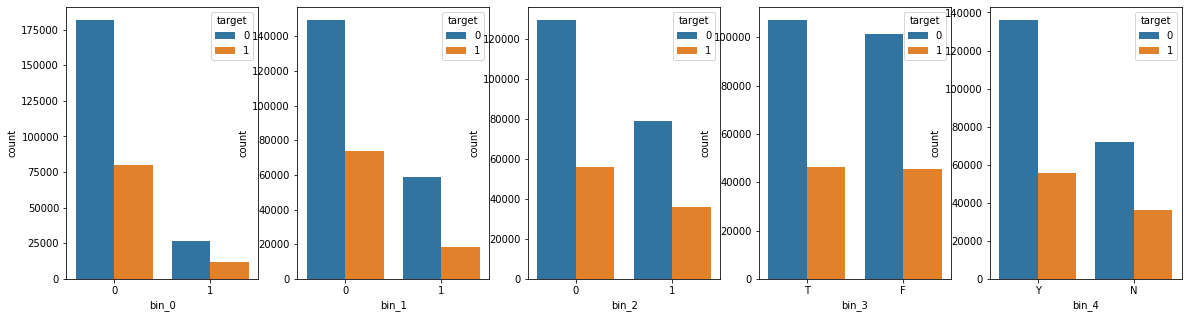

In [0]:
##### binary variables vs Target distribution
bin_cols = ['bin_0','bin_1','bin_2','bin_3','bin_4']
nrows = 1
ncols = int(len(bin_cols))

fig,axs = plt.subplots(nrows,ncols,figsize = (20,5))
for i,c in enumerate(bin_cols):
  sb.countplot(x = train[c],hue = train['target'],ax = axs[i])


#### Observation : In bin_3 the proportion of 0/1 in T/F are approximately similar. We can see if this variable can provide any information else it can be dropped. \
#### We can one hot encode these features replacing strings to corresponding numerical values.

In [0]:
#### Distribution of nomila variables
nom_cols = ['nom_0','nom_1','nom_2','nom_3','nom_4']
for c in nom_cols:
  print('Distribution of categories in {} : %s'.format(c) % (train[c].value_counts()))

Distribution of categories in nom_0 : Green    127341
Blue      96166
Red       76493
Name: nom_0, dtype: int64
Distribution of categories in nom_1 : Trapezoid    101181
Square        49597
Star          45904
Circle        37320
Polygon       36143
Triangle      29855
Name: nom_1, dtype: int64
Distribution of categories in nom_2 : Lion       101295
Cat         49659
Snake       45979
Dog         37444
Axolotl     36136
Hamster     29487
Name: nom_2, dtype: int64
Distribution of categories in nom_3 : Russia        101123
Canada         49951
China          46044
Finland        36942
Costa Rica     35988
India          29952
Name: nom_3, dtype: int64
Distribution of categories in nom_4 : Oboe        92293
Piano       84517
Bassoon     68448
Theremin    54742
Name: nom_4, dtype: int64


In [0]:
#### nom_0 to nom_4 have less number of unique values as compared to other nom variable. We can plot their distribution with target.
nrows = 1
ncols = int(len(nom_cols))

fig,axs = plt.subplots(nrows,ncols,figsize = (20,5))
for i,c in enumerate(bin_cols):
  sb.countplot(x = train[c],hue = train['target'],ax = axs[i])


In [0]:
low_card_nom_vars = [ for x in train.columns if 'nom' in x and train[x].nunique() < 12 ]

In [0]:
class Cat_Encode:
        
    ### Encoding categorical variables using category_encoders package. 
    ### This returns a transformed dataframe.
    
    def __init__(self,methods,**params):
        self.methods = methods
        self.params = params
        self.method_obj = self.get_method_obj()
        
    def get_method_obj(self):
        if self.methods == 'target_encode':
             return ce.target_encoder.TargetEncoder(**self.params)
        elif self.methods == 'woe':
            return ce.woe.WOEEncoder(**self.params)
        elif self.methods == 'ohe':
            return ce.one_hot.OneHotEncoder(**self.params)
        elif self.methods == 'helmert':
            return ce.helmert.HelmertEncoder(**self.params)
        elif self.methods == 'james-stein':
            return ce.james_stein.JamesSteinEncoder(**self.params)
        elif self.methods == 'loo':
            return ce.leave_one_out.LeaveOneOutEncoder(**self.params)
        elif self.methods == 'm-estimate':
            return ce.m_estimate.MEstimateEncoder(**self.params)
        elif self.methods == 'hashing':
            return ce.hashing.HashingEncoder(**self.params)
        elif self.methods == 'cat_boost':
            return ce.cat_boost.CatBoostEncoder(**self.params)
        elif self.methods == 'binary':
            return ce.binary.BinaryEncoder(**self.params)
        else:
            print("Methods can be from : [target_encode,woe,ohe,m-estimate,hashing,cat_boost,binary]")
    
    def print_method(self):
        print(self.method_obj)
        
    def return_method_obj(self):
        return self.method_obj
        
    def fit_(self,data,**kwargs):
        self.method_fit_ = self.method_obj.fit(data,**kwargs)
        return self
    
    def transform_(self,data):
        self.method_transform_ = self.method_obj.transform(data)
        return self.method_transform_

    def fit_transform_(self,data,**kwargs):
        return self.method_obj.fit_transform(data,**kwargs)
        

In [0]:
class Model_Build:
    
    def __init__(self,model,cv_type = 'stratified k fold',scoring = None,verbose = 0,cv_params = None,feat_sel = None):
        self.model = model
        self.cv_type = cv_type
        self.scoring = scoring
        self.verbose = verbose
        self.cv_params  = cv_params
        self.feat_sel_func = feat_sel
        
    def _check_cv_type(self):
        assert isinstance(self.cv,int) , 'CV must be of type int'
        assert isinstance(self.cv_type,str), 'CV type must be of string and can be : stratified k fold,k fold,repeated k fold,repeated stratified k fold'
            
    
    def get_cv_func(self):
        if self.cv_type == 'stratified k fold':
            return StratifiedKFold(**self.cv_params)
        elif self.cv_type == 'k fold':
            return KFold(**self.cv_params)
        elif self.cv_type == 'repeated k fold':
            return RepeatedKFold(**self.cv_params)
        elif self.cv_type == 'repeated stratified k fold':
            return RepeatedStratifiedKFold(**self.cv_params)
        else:
            self._check_cv_type()
        
    def get_cv_folds(self,X,Y):
        
        cv_func = self.get_cv_func()
        print(cv_func)
        train_ind_list = []
        test_ind_list = []
        for train_ind,test_ind in cv_func.split(X,Y):
            train_ind_list.append(train_ind)
            test_ind_list.append(test_ind)
        
        return train_ind_list,test_ind_list
    
    def cv_feat_process(self,X,cv_feat_func,Y = None,data_class = None):
        if data_class == 'train':
            return cv_feat_func.fit_transform_(X,y = Y)
        elif data_class == 'test':
            return cv_feat_func.transform_(X)
        
    def feat_sel_(self,X,Y= None,data_class = None):
        if data_class == 'train':
            return self.feat_sel_func.fit_transform_(X,y = Y)
        else:
            return self.feat_sel_func.transform_(X)
    
    def cv_fit_(self,X,Y,sample_weight = None,cv_feat_func = None):
        train_cv_ind,test_cv_ind = self.get_cv_folds(X,Y)
        cv_scores = []
        k = 1
        for i,j in zip(train_cv_ind,test_cv_ind):
            #print('-------- Started for fold : %s -------' % (k))
            x_train,x_val,y_train,y_val = X.loc[i,:],X.loc[j,:],Y[i],Y[j]
            
            #### Calculating sample weights
            wts = y_train[y_train == 0].shape[0]/y_train[y_train == 1].shape[0]
            samp_wt = y_train.apply( lambda x: wts if x==1 else 1)
            
            if cv_feat_func!=None: 
                x_train = self.cv_feat_process(x_train,cv_feat_func,Y = y_train,data_class = 'train')
                x_val = self.cv_feat_process(x_val,cv_feat_func,data_class = 'test')
            
            if self.feat_sel_func != None:
                #a1 = x_train[x_train.drop(high_card_feats,axis = 1)<0].sum().reset_index()
                #neg_cols = a1[a1[0]!=0]['index'].tolist()
                x_train = self.feat_sel_(x_train,Y = y_train,data_class = 'train')
                x_val = self.feat_sel_(x_val,data_class = 'test')
                
                #x_train = pd.concat([pd.DataFrame(x_train_1,index = x_train.index),x_train[neg_cols]],axis = 1)
                #x_val = pd.concat([pd.DataFrame(x_val_1,index = x_val.index),x_val[neg_cols]],axis = 1)
                
            x_train.index = range(x_train.shape[0])
            x_val.index = range(x_val.shape[0])
            
            model_fit = self.model.fit(x_train,y_train,sample_weight = samp_wt) if sample_weight == True else self.model.fit(x_train,y_train)
            model_preds = model_fit.predict_proba(x_val)
            cv_scores.append(self.scoring(y_val,model_preds[:,1]))
            #print('Score : %s' % (cv_scores[k-1]))
            k = k+1
        
        return cv_scores
    
    def fit_(self,X,Y,sample_weight = None,cv_feat_func = None):
        if cv_feat_func!=None : 
            X = self.cv_feat_process(X,cv_feat_func,Y= Y,data_class = 'train')
            
        wts = y_train[y_train == 0].shape[0]/y_train[y_train == 1].shape[0]
        samp_wt = y_train.apply( lambda x: wts if x==1 else 1)
            
        self.model_fit = self.model.fit(X,Y,sample_weight = samp_wt) if sample_weight == True else self.model.fit(X,Y)
    
    def predict_proba(self,X,cv_feat_func = None):
        if cv_feat_func!=None : 
            X = self.cv_feat_process(X,cv_feat_func,data_class = 'train')
        return  self.model_fit.predict_proba(X)  
    

In [0]:
class Feat_Preprocess:
    def __init__(self,cyc_encode = True,ohe_encode = True):
        self.cyc_encode = cyc_encode
        self.ohe_encode = ohe_encode
        
    def cyc(self,col, max_val = None):
        for c in col:
            if max_val == None:
                max_val = self.X[c].max()
            self.X[c + '_sin'] = np.sin(2 * np.pi * self.X[c]/max_val)
            self.X[c + '_cos'] = np.cos(2 * np.pi * self.X[c]/max_val)
    
    
    def ohe(self):
        self.X = pd.get_dummies(self.X,columns = self.cols_to_dummy,drop_first = True)
        
    def fit_(self,X,cyc_col = None,ohe_cols = None):
        self.X = X
        
        if self.cyc_encode:
            self.cyc(cyc_col)
        
        if self.ohe_encode:
            self.cols_to_dummy = ohe_cols
            self.ohe()
        
        return self.X
            

In [0]:
##### Encoding cyclical features
cols_to_dummy =[ x for x in  df1[(df1[0]>=2) & (df1[0]<=12)]['index'].values.tolist() if x not in ['day','month'] ]
train['flag'] = ['train']*train.shape[0]
test['flag'] = ['test']*test.shape[0]
total_data = pd.concat([train,test],axis = 0)
total_data_1 = Feat_Preprocess(cyc_encode=True,ohe_encode=False).fit_(total_data,cyc_col = ['day','month'])
train_1 = total_data_1[total_data_1['flag'] == 'train']
test_1 = total_data_1[total_data_1['flag'] == 'test']
cols_to_drop = ['id','day','month','target','flag']

In [0]:
x_train,x_test,y_train,y_test = train_test_split(train_1.drop(cols_to_drop,axis = 1),train_1['target'],test_size = 0.3,stratify = train_1['target'])
x_train.index = range(x_train.shape[0])
x_test.index = range(x_test.shape[0])
y_train.index = range(y_train.shape[0])
y_test.index = range(y_test.shape[0])

In [0]:
best_loss = float('-inf')
obj_call_count = 0
cat_feats = train_1.select_dtypes(include = object).columns.tolist()

trials = Trials()

def get_params(params,int_params):
  for x in int_params:
    params[x] = int(params[x])
  return params

tar_encode = Cat_Encode(methods = "target_encode", cols=x_train.select_dtypes(include = object).columns.tolist(), min_samples_leaf=100, smoothing=1)

global integer_params

def objective(params):
    
    global best_loss,obj_call_count,integer_params,cat_feats

    params_new = get_params(params,integer_params) if integer_params != None else params

    obj_call_count += 1
    
    sorted_params = sorted(params.items(), key=lambda z: z[0])
    params_str = str.join(' ', ['{}={}'.format(k, v) for k, v in sorted_params])
    print('Iteration Number : %s' % (obj_call_count))
    print('Params: {}'.format(params_str) )

    global model
    '''
    model = CatBoostClassifier(devices = '0:4',task_type = 'GPU',
                         loss_function='Logloss',early_stopping_rounds=50,
                         od_type = 'Iter',cat_features=cat_feats,
                         verbose= False,**params_new)
    '''
    

    m = Model_Build(model = model,cv_params={'n_splits' : 3,'random_state' : 1993},scoring = roc_auc_score)
    cv_scores = m.cv_fit_(train_1.drop(['target'],axis = 1),train_1['target'],sample_weight = True)
    mean_cv_score = -1*np.mean(cv_scores)
    
    if mean_cv_score<best_loss:
        best_loss = mean_cv_score
        
    return{'loss':mean_cv_score, 'status': STATUS_OK }
    

In [0]:
############### Training data with cat features passed to catboost algorithm

search_spaces = {'iterations': hp.choice('iterations',[10,50,100,500,1000]),
                 'depth': hp.choice('depth',[3,5,7,9]),
                 'learning_rate': hp.uniform('learning_rate',0.01, 0.3),
                 'random_strength': hp.loguniform('random_strength',1e-9, 10),
                 'bagging_temperature': hp.uniform('bagging_temperature',0.0, 1.0),
                 'border_count': hp.uniform('border_count',1, 255),
                 'l2_leaf_reg': hp.uniform('l2_leaf_reg',2, 30),
                 'scale_pos_weight':hp.uniform('scale_pos_weight',0.01, 1.0)}
    
integer_params = ['border_count']
HYPEROPT_ALGO = tpe.suggest
best1 = fmin(fn = objective,space = search_spaces ,algo = HYPEROPT_ALGO,trials= trials,verbose = 2,show_progressbar=False,max_evals=50)

Iteration Number : 1
Params: bagging_temperature=0.7722632583053209 border_count=120 depth=9 iterations=100 l2_leaf_reg=18.632755798782526 learning_rate=0.09597334464753274 random_strength=106.76633916132883 scale_pos_weight=0.8587922884521421
StratifiedKFold(n_splits=3, random_state=1993, shuffle=False)
Iteration Number : 2
Params: bagging_temperature=0.6051753357353193 border_count=30 depth=7 iterations=50 l2_leaf_reg=25.237741242601285 learning_rate=0.1903271270065517 random_strength=367.3922965941629 scale_pos_weight=0.17617079419907272
StratifiedKFold(n_splits=3, random_state=1993, shuffle=False)
Iteration Number : 3
Params: bagging_temperature=0.08623528430077865 border_count=115 depth=9 iterations=100 l2_leaf_reg=13.72774951939661 learning_rate=0.10941017598994623 random_strength=50.170285259275225 scale_pos_weight=0.5177653822813121
StratifiedKFold(n_splits=3, random_state=1993, shuffle=False)
Iteration Number : 4
Params: bagging_temperature=0.40624786850004924 border_count=70 

In [0]:
with open('best1.txt', 'w') as f:
    print(best1, file=f)

In [0]:
search_spaces = {'iterations': hp.choice('iterations',[10,50,100,500,1000]),
                 'depth': hp.choice('depth',[3,5,7,9]),
                 'learning_rate': hp.uniform('learning_rate',0.01, 0.3),
                 'random_strength': hp.loguniform('random_strength',1e-9, 10),
                 'bagging_temperature': hp.uniform('bagging_temperature',0.0, 1.0),
                 'border_count': hp.uniform('border_count',1, 255),
                 'l2_leaf_reg': hp.uniform('l2_leaf_reg',2, 30),
                 'scale_pos_weight':hp.uniform('scale_pos_weight',0.01, 1.0)}

integer_params = None
HYPEROPT_ALGO = tpe.suggest
best = fmin(fn = objective,space = search_spaces ,algo = HYPEROPT_ALGO,trials= trials,verbose = 2,show_progressbar=False,max_evals=30)

Iteration Number : 1
Params: bagging_temperature=0.24227724080125612 border_count=232.67559840371328 depth=3 iterations=10 l2_leaf_reg=24.405011452031367 learning_rate=0.15400256964764325 random_strength=1.3240644096484215 scale_pos_weight=0.153462901408725
StratifiedKFold(n_splits=3, random_state=1993, shuffle=False)
Iteration Number : 2
Params: bagging_temperature=0.6532614727601372 border_count=81.54437699460703 depth=3 iterations=100 l2_leaf_reg=25.558403966606463 learning_rate=0.026474977435135827 random_strength=100.15074052021455 scale_pos_weight=0.4585159981931401
StratifiedKFold(n_splits=3, random_state=1993, shuffle=False)
Iteration Number : 3
Params: bagging_temperature=0.8803958462174782 border_count=108.14189028748002 depth=9 iterations=1000 l2_leaf_reg=10.347389361269576 learning_rate=0.22695800454586895 random_strength=4223.660437300071 scale_pos_weight=0.2732953341272228
StratifiedKFold(n_splits=3, random_state=1993, shuffle=False)
Iteration Number : 4
Params: bagging_t

In [0]:
#model = LGBMClassifier(random_state = 1993,boosting_type='gbdt',num_estimators = 100,learning_rate=0.1,num_leaves=50)
# optimal params for target encode : min_samples_leaf=100, smoothing=1
#model = CatBoostClassifier(random_state = 1993,verbose = 0)
#tar_encode = Cat_Encode(methods = "target_encode", cols=high_card_feats + cols_to_dummy, min_samples_leaf=100, smoothing=1)
#m = Model_Build(model = model,cv_params={'n_splits' : 3,'random_state' : 1993},scoring = roc_auc_score)
#m.cv_fit_(x_train,y_train,cv_feat_func=tar_encode,sample_weight = True)

In [0]:
'''
tar_encode = Cat_Encode(methods = "target_encode", cols=high_card_feats+cols_to_dummy, min_samples_leaf=100, smoothing=1)
x_train_encode = tar_encode.fit_transform_(x_train,y = y_train)
x_test_encode = tar_encode.transform_(x_test)

wts = y_train[y_train == 0].shape[0]/y_train[y_train == 1].shape[0]
sample_weight = y_train.apply( lambda x: wts if x==1 else 1)
            
model_fit_1 = CatBoostClassifier(random_state = 1993,verbose= 0).fit(x_train_encode,y_train,sample_weight=sample_weight)
model_preds_1 = model_fit_1.predict_proba(x_test_encode)
print(roc_auc_score(y_test,model_preds_1[:,1]))
'''

In [0]:
#tar_encode = Cat_Encode(methods = "target_encode", cols=high_card_feats, min_samples_leaf=100, smoothing=1)
#train_encode = tar_encode.fit_transform_(train_2.drop(cols_to_drop,axis = 1),y = train_1['target'])
#test_encode = tar_encode.transform_(test_2.drop(cols_to_drop,axis = 1))

model_fit_2 = CatBoostClassifier(devices = '0:4',task_type = 'GPU',
                         loss_function='Logloss',early_stopping_rounds=50,
                         od_type = 'Iter',cat_features=high_card_feats,
                         verbose= False,**best).fit(train_2,train_1['target'])
model_preds_2 = model_fit_2.predict_proba(test_2)

In [0]:
output = pd.DataFrame({'id' : test_new['id'],'target' : model_preds_2[:,-1]},index = range(test_new.shape[0]))
output.to_csv('Output_CB_Hopt.csv',index = False)